In [1]:
%matplotlib inline

from helper_function1 import *
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import LinearSVC
import pickle
from IPython.display import display
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

'output_frames/40.png'

(720, 1280, 3)


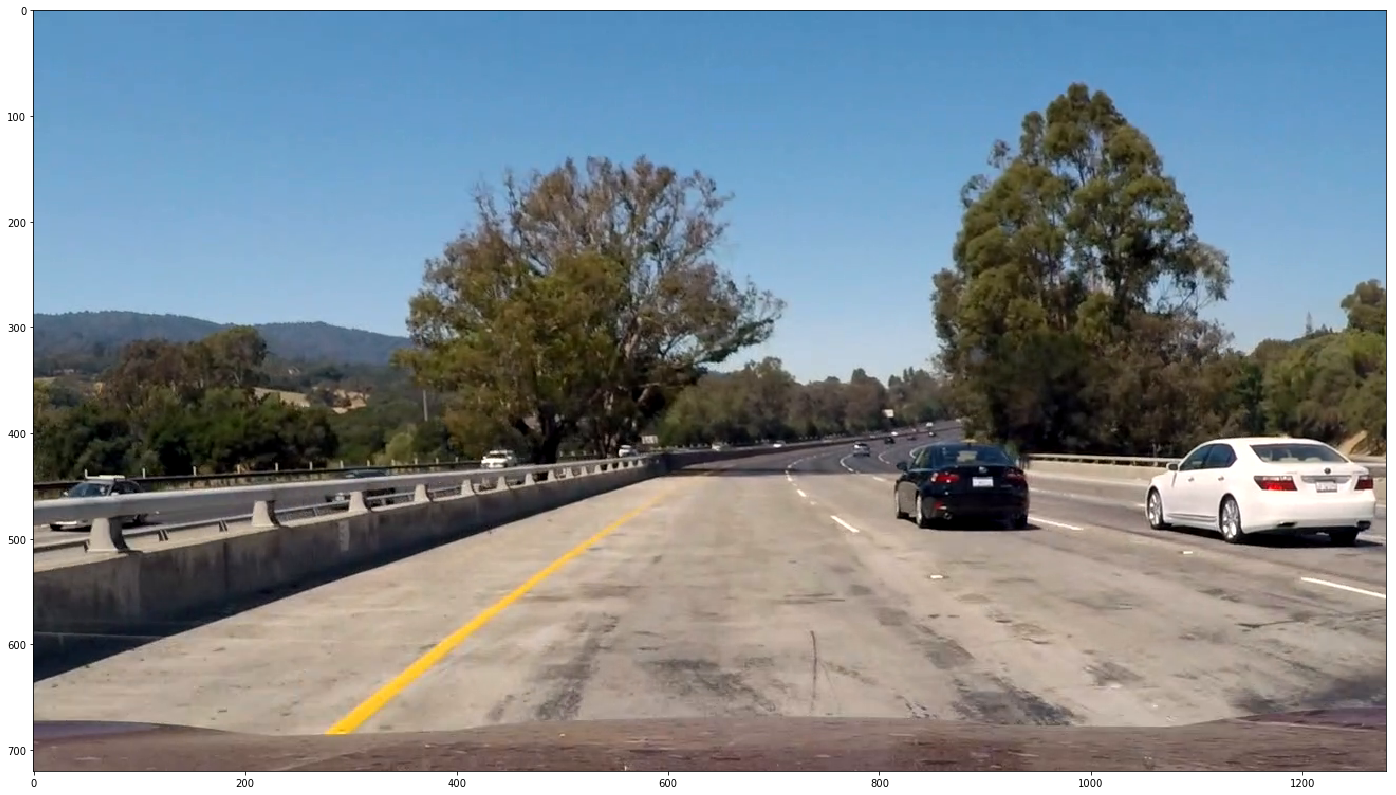

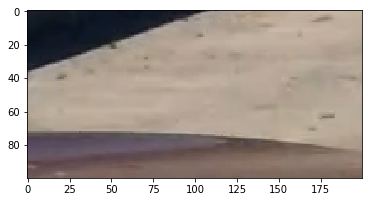

In [2]:
test_img="output_frames/40.png"

display(test_img)
img=mpimg.imread(test_img)
plt.figure(figsize=(25,14))
plt.imshow(img)
print(img.shape)

plt.figure()
plt.imshow(img[600:700, 0:200])

In [3]:
# Load trained classifier 

clf = pickle.load(open('trained_classifier.pkl', 'rb'))
print(clf)
X_scaler = pickle.load(open('x_scaler.pkl', 'rb'))

LinearSVC(C=0.0021544346900318843, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)


In [4]:
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 700] # Min and max in y to search in slide_window()

Temp window size  2040
Temp window size  329
Final window size:  2369


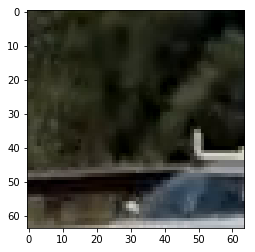

In [22]:
# Extract segments from image

#output format ((startx, starty), (endx, endy))
#xy_windows = [[32,32], [64,64], [128,128]]
xy_windows = [[64,64], [128,128]]

xy_overlap = [0.8,0.8]
windows = []
for xy_window in xy_windows:
    tmp_window = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    print("Temp window size ", len(tmp_window))
    windows = windows + tmp_window
    
print("Final window size: ", len(windows))
first = windows[0]
plt.imshow(img[first[0][1]:first[1][1], first[0][0]:first[1][0]])

In [23]:
selected_windows = []


for window in windows:
    image_window = extract_image_window(img, window)
    # Resize it to 64x64
    image_window = cv2.resize(image_window, (64,64))
    image_features = extract_features_for_one_image(image_window, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)
    #print(image_features.shape)
    image_features = image_features.reshape(1, -1)
    scaled_features = X_scaler.transform(image_features)
    prediction = clf.predict(scaled_features)
    if prediction == 1:
        selected_windows.append(window)

In [24]:
print(len(selected_windows))
print(selected_windows)

40
[((96, 400), (160, 464)), ((708, 400), (772, 464)), ((1080, 400), (1144, 464)), ((816, 412), (880, 476)), ((828, 412), (892, 476)), ((840, 412), (904, 476)), ((852, 412), (916, 476)), ((864, 412), (928, 476)), ((864, 424), (928, 488)), ((1056, 424), (1120, 488)), ((1068, 424), (1132, 488)), ((804, 436), (868, 500)), ((816, 436), (880, 500)), ((828, 436), (892, 500)), ((864, 436), (928, 500)), ((876, 436), (940, 500)), ((1068, 436), (1132, 500)), ((804, 448), (868, 512)), ((816, 448), (880, 512)), ((828, 448), (892, 512)), ((840, 448), (904, 512)), ((852, 448), (916, 512)), ((864, 448), (928, 512)), ((876, 448), (940, 512)), ((888, 448), (952, 512)), ((1032, 448), (1096, 512)), ((1044, 448), (1108, 512)), ((1056, 448), (1120, 512)), ((1176, 448), (1240, 512)), ((1188, 448), (1252, 512)), ((1200, 448), (1264, 512)), ((1212, 448), (1276, 512)), ((1092, 460), (1156, 524)), ((1104, 460), (1168, 524)), ((1116, 460), (1180, 524)), ((1140, 460), (1204, 524)), ((825, 400), (953, 528)), ((112

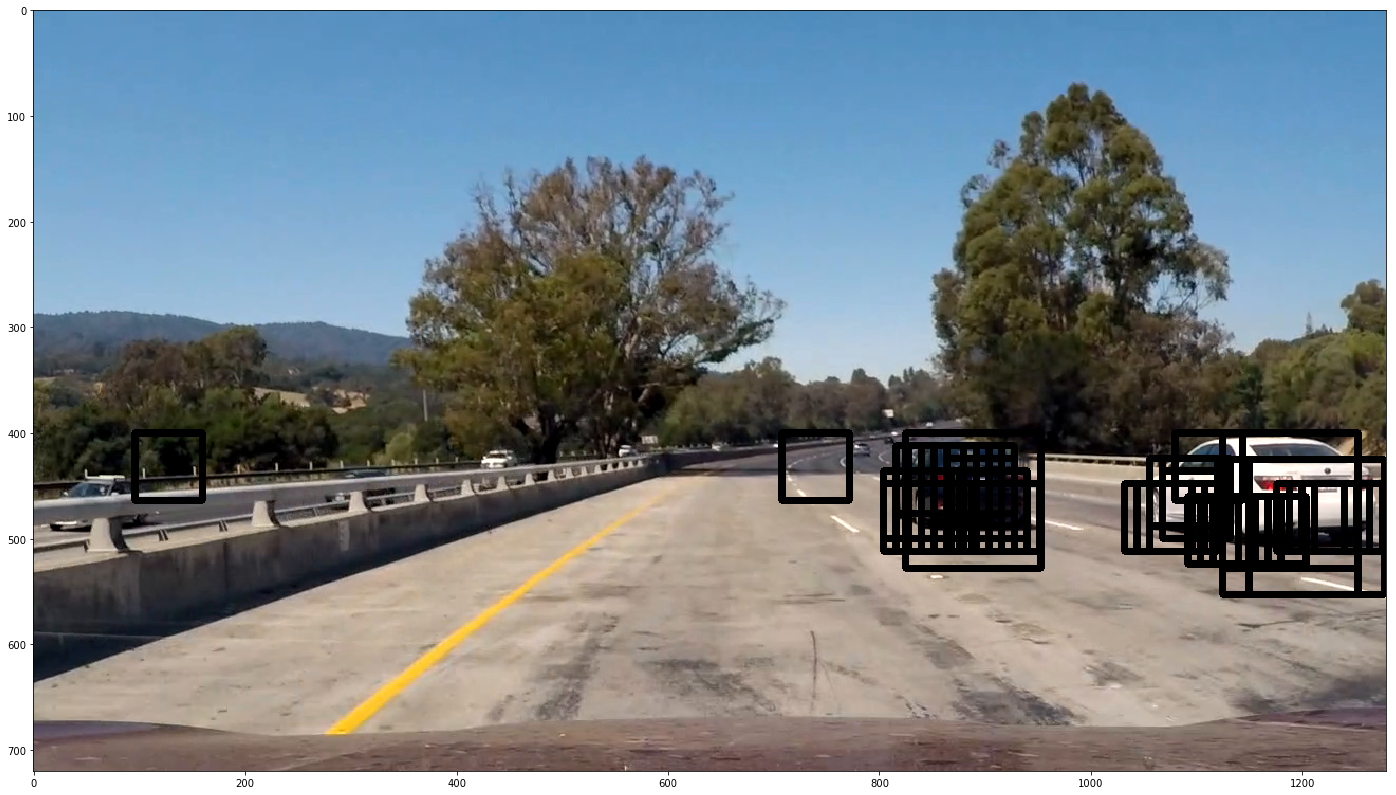

In [25]:
# Draw windows

img_copy = draw_boxes(img, selected_windows)
plt.figure(figsize=(25, 14))
plt.imshow(img_copy)

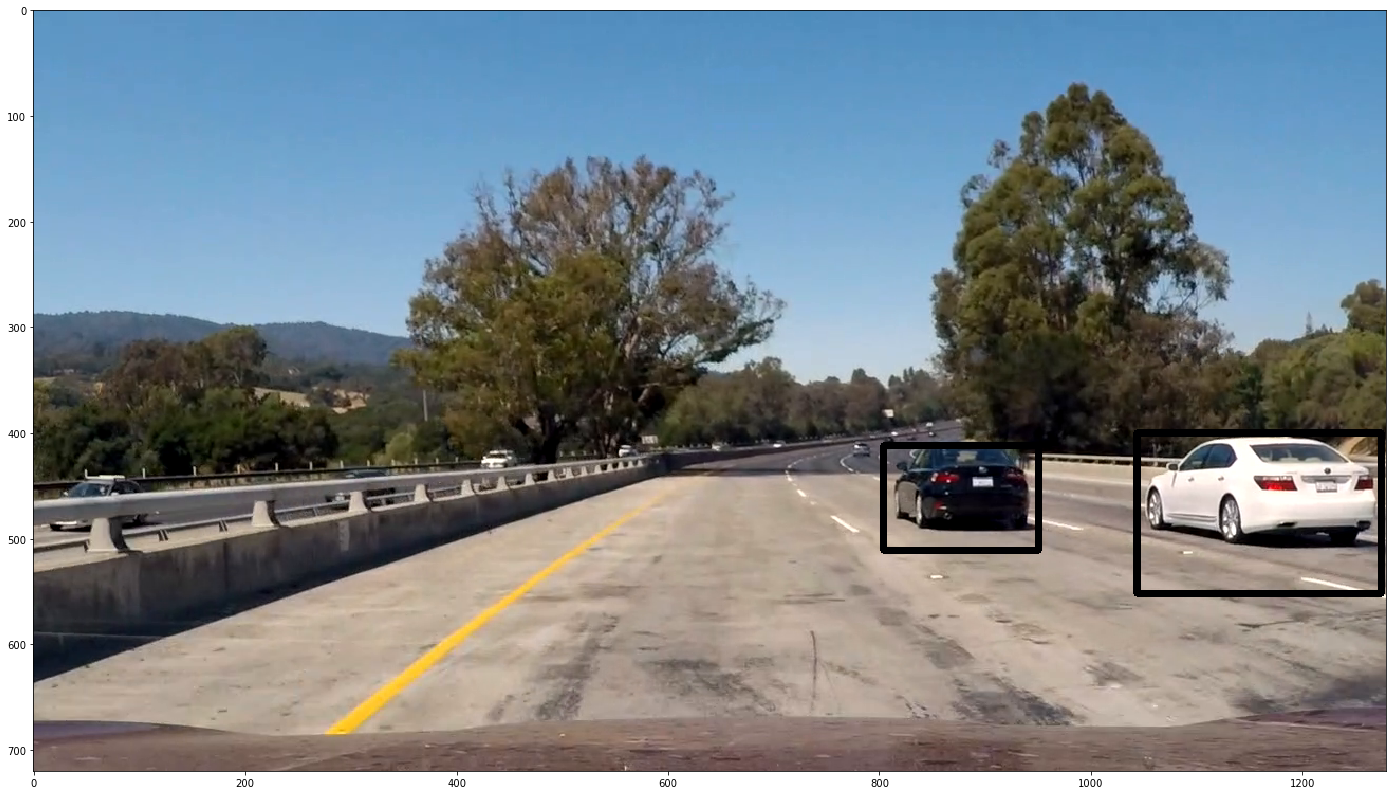

In [30]:
from scipy.ndimage.measurements import label

img_copy = img.copy()

heat = np.zeros_like(img_copy[:,:,0]).astype(np.float)

heat = add_heat(heat, selected_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

labels = label(heatmap)
draw_img = draw_labeled_bboxes(img_copy, labels)

plt.figure(figsize=(25,14))
plt.imshow(draw_img)